In [ ]:
#IMPORTS
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio, display
import ipywidgets as widgets
import pandas as pd
import os
import random
from scipy.io.wavfile import write
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions
Math
- Vmap/Amap

Visualisations
- plot_audio_and_segmented_spectrograms


In [ ]:


# Definition for vmap and amap are taken from https://www.sciencedirect.com/science/article/pii/S0957417422010740

def create_vmap(spectrogram):
    """
    Creates the vmap (velocity map) of a given spectrogram. The vmap represents the temporal derivative
    of the spectrogram, providing information about the changes in frequency content over time.

    Args:
        spectrogram (numpy.ndarray): Input spectrogram with shape (T, f), where T is the number of time frames
                                     and f is the number of frequency bins.

    Returns:
        numpy.ndarray: The vmap of the spectrogram with the same shape as the input spectrogram.
    """
    T, f = spectrogram.shape

    vmap = np.zeros_like(spectrogram)

    for t in range(T):
        if t == 0:
            vmap[t, :] = spectrogram[t + 1, :] - spectrogram[t, :]
        elif t == T - 1:
            vmap[t, :] = spectrogram[t, :] - spectrogram[t - 1, :]
        else:
            vmap[t, :] = (spectrogram[t + 1, :] - spectrogram[t - 1, :]) / 2

    return vmap

def create_amap(vmap):
    """
    Creates the amap (acceleration map) of a given vmap. The amap represents the second temporal derivative
    of the spectrogram, providing information about the acceleration of changes in frequency content over time.

    Args:
        vmap (numpy.ndarray): Input vmap with shape (T, f), where T is the number of time frames
                              and f is the number of frequency bins.

    Returns:
        numpy.ndarray: The amap of the vmap with the same shape as the input vmap.
    """
    T, f = vmap.shape

    amap = np.zeros_like(vmap)

    for t in range(T):
        if t == 0:
            amap[t, :] = vmap[t + 1, :] - vmap[t, :]
        elif t == T - 1:
            amap[t, :] = vmap[t, :] - vmap[t - 1, :]
        else:
            amap[t, :] = (vmap[t + 1, :] - vmap[t - 1, :]) / 2

    return amap



In [ ]:
def plot_audio_and_segmented_spectrograms(audio_file_path, segment_length=2):
    """
    Plots the waveform and segmented spectrograms of an audio file. Additionally, it computes and displays
    the velocity map (vmap) and acceleration map (amap) for both the full spectrogram and each segment.

    Args:
        audio_file_path (str): Path to the audio file to be processed.
        segment_length (int, optional): Length of each segment in seconds. Default is 2 seconds.

    Returns:
        None
    """
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)

    # Resample the audio to 16 kHz
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)
    sr_resampled = 16000

    # Plot the waveform
    plt.figure(figsize=(12, 4))
    plt.plot(y)
    plt.title(f'Waveform (Dimensions: {y.shape})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

    # Display the audio player for resampled audio
    audio_button = widgets.Button(description="Play Audio")
    display(audio_button)
    audio_widget = Audio(data=y_resampled, rate=sr_resampled, autoplay=False)
    output = widgets.Output()

    def on_button_click(b):
        with output:
            display(audio_widget)

    audio_button.on_click(on_button_click)
    display(output)

    # Compute the mel spectrogram with the specified settings
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=31,
                                       fmin=1, fmax=1000, window='hann',
                                       n_mels=128, power=2.0, center=False)

    # Convert to decibels
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Create vmap and amap for the full spectrogram
    vmap_full = create_vmap(S_dB)
    amap_full = create_amap(vmap_full)

    # Plot the full spectrogram, vmap, and amap
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    img = librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmin=1, fmax=1000, ax=axes[0])
    fig.colorbar(img, ax=axes[0], format='%+2.0f dB')
    axes[0].set_title(f'Full Mel Spectrogram (Dimensions: {S_dB.shape})')

    img = librosa.display.specshow(vmap_full, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmin=1, fmax=1000, ax=axes[1])
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    axes[1].set_title(f'vmap for Full Spectrogram (Dimensions: {vmap_full.shape})')

    img = librosa.display.specshow(amap_full, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmin=1, fmax=1000, ax=axes[2])
    fig.colorbar(img, ax=axes[2], format='%+2.0f dB')
    axes[2].set_title(f'amap for Full Spectrogram (Dimensions: {amap_full.shape})')

    plt.tight_layout()
    plt.show()

    # Determine the number of frames per segment
    hop_length = 31
    segment_frames = segment_length * sr // hop_length

    # Calculate the total number of segments
    num_segments = S_dB.shape[1] // segment_frames

    # Plot each segment
    for i in range(num_segments):
        start_frame = i * segment_frames
        end_frame = start_frame + segment_frames
        segment = S_dB[:, start_frame:end_frame]

        # Create vmap and amap for the segment
        vmap = create_vmap(segment)
        amap = create_amap(vmap)

        fig, axes = plt.subplots(1, 3, figsize=(18, 4))

        # Plot the segment spectrogram
        img = librosa.display.specshow(segment, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmin=1, fmax=1000, ax=axes[0])
        fig.colorbar(img, ax=axes[0], format='%+2.0f dB')
        axes[0].set_title(f'Segment {i+1} (Dimensions: {segment.shape})')

        # Plot the vmap
        img = librosa.display.specshow(vmap, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmin=1, fmax=1000, ax=axes[1])
        fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
        axes[1].set_title(f'vmap for Segment {i+1} (Dimensions: {vmap.shape})')

        # Plot the amap
        img = librosa.display.specshow(amap, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmin=1, fmax=1000, ax=axes[2])
        fig.colorbar(img, ax=axes[2], format='%+2.0f dB')
        axes[2].set_title(f'amap for Segment {i+1} (Dimensions: {amap.shape})')

        plt.tight_layout()
        plt.show()


# Creation and Storage of Spectrograms

In [ ]:
def create_and_store_spectrograms(audio_file_path, csv_label_path, output_path, segment_length=2, step_size_in_sec=0.1):
    """
    Processes an audio file and its corresponding label CSV file to create segments and labels.
    Each segment is saved as a tensor with its corresponding label.

    Args:
        audio_file_path (str): Path to the audio file.
        csv_label_path (str): Path to the CSV file containing labels.
        output_path (str): Path to the directory where the output tensors will be saved.
        segment_length (int, optional): Length of each segment in seconds. Default is 2 seconds.
        step_size_in_sec (float, optional): Step size in seconds for segmenting the audio. Default is 0.1 seconds.

    Returns:
        tuple: A tuple containing the number of segments created, the number of segments labeled as 0,
               and the number of segments labeled as 1.
    """
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Compute the mel spectrogram with the specified settings
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=31,
                                       fmin=1, fmax=1000, window='hann',
                                       n_mels=128, power=2.0, center=False)

    # Convert to decibels
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Load the CSV labels
    labels = pd.read_csv(csv_label_path).iloc[:, 0].values

    # Calculate the number of segments and step sizes in frames
    num_segments = int(len(y) / (step_size_in_sec * sr) - (sr * 2) / (step_size_in_sec * sr))
    step_size_spectrograms = S_dB.shape[1] // num_segments

    # Initialize counters
    num_zero_labels = 0
    num_one_labels = 0
    start_frame_spectrograms = 0
    start_frame_labels = 0

    # Loop through the audio file and create segments
    for i in range(num_segments):
        # Calculate end frame of the segment
        end_frame_spectrograms = start_frame_spectrograms + 128
        end_frame_labels = end_frame_spectrograms * (len(y) // S_dB.shape[1])

        segment = S_dB[:, start_frame_spectrograms:end_frame_spectrograms]
        segment_labels = labels[start_frame_labels:end_frame_labels]

        if segment.shape[1] < 128:
            start_frame_spectrograms += step_size_spectrograms
            start_frame_labels = start_frame_spectrograms * (len(y) // S_dB.shape[1])
            continue

        # Ensure the segment is 128x128
        if segment.shape[1] != 128:
            segment = segment[:, 1:129]

        # Create vmap and amap
        vmap = create_vmap(segment)
        amap = create_amap(vmap)

        # Determine the label based on the 75% condition
        if np.sum(segment_labels == 1) / len(segment_labels) > 0.3:
            most_common_label = 1
        else:
            most_common_label = 0

        # Update counters
        if most_common_label == 0:
            num_zero_labels += 1
        elif most_common_label == 1:
            num_one_labels += 1

        # Combine the spectrogram, vmap, and amap into a 3x128x128 tensor
        combined_tensor = torch.tensor(np.stack([segment, vmap, amap], axis=0), dtype=torch.float32)

        # Store corresponding label in the label tensor
        label_tensor = torch.tensor(most_common_label, dtype=torch.int64)

        # Save Spectrogram Tensor
        segment_name = f"{os.path.splitext(os.path.basename(audio_file_path))[0]}_segment_{i}"
        combined_tensor_path = os.path.join(output_path, f"{segment_name}_combined.pt")
        torch.save(combined_tensor, combined_tensor_path)

        # Save label tensor
        label_tensor_path = os.path.join(output_path, f"{segment_name}_label.pt")
        torch.save(label_tensor, label_tensor_path)

        # Update start frames
        start_frame_spectrograms += step_size_spectrograms
        start_frame_labels = start_frame_spectrograms * (len(y) // S_dB.shape[1])

    # Return statistics
    return num_segments, num_zero_labels, num_one_labels

# Example usage
input_path = "./FixingAudioSpectrograms"
output_path = "./FINISHED_PRODUCT.3"

# Iterate through all label and audio files in the directory
tot_segments = 0
tot_zeros = 0
tot_ones = 0
tot_files = 0
for filename in os.listdir(input_path):
    if filename.endswith('.wav'):
        audio_file_path = os.path.join(input_path, filename)
        csv_label_path = os.path.join(input_path, filename.replace('.wav', '_labels.csv'))
        num_segments, num_zero_labels, num_one_labels = create_and_store_spectrograms(audio_file_path, csv_label_path, output_path)
        tot_segments += num_segments
        tot_zeros += num_zero_labels
        tot_ones += num_one_labels
        tot_files += 1
print("Total number of segments:", tot_segments)
print("Total number of zero labels:", tot_zeros)
print("Total number of one labels:", tot_ones)
print("Total number of files:", tot_files)


# Visualising

In [ ]:

folder_path = '/content/drive/My Drive/Orig_CSV_Files'
os.listdir(folder_path)


['09_swallow_water.csv',
 '29_swallow_water_continuously.csv',
 '19_swallow_dry.csv',
 '20_swallow_water.csv',
 '10_swallow_water.csv',
 '04_swallow_water_N2.csv',
 '11_swallow_water.csv',
 '26_swallow_water.csv',
 '23_swallow_dry.csv',
 '22_swallow_dry.csv',
 '01_swallow_banana.csv',
 '04_swallow_banana.csv',
 '10_swallow_dry.csv',
 '21_swallow_water.csv',
 '11_swallow_banana.csv',
 '06_swallow_dry.csv',
 '24_swallow_banana.csv',
 '28_swallow_water_continuously.csv',
 '22_swallow_banana_N2.csv',
 '21_swallow_banana.csv',
 '09_swallow_banana.csv',
 '09_swallow_dry.csv',
 '02_swallow_banana_N2.csv',
 '23_swallow_water.csv',
 '08_swallow_water.csv',
 '25_swallow_water.csv',
 '11_swallow_dry.csv',
 '24_swallow_dry.csv',
 '14_swallow_banana.csv',
 '15_swallow_water.csv',
 '10_swallow_banana_N3.csv',
 '19_swallow_banana.csv',
 '28_swallow_continuous_water.csv',
 '14_swallow_banana_N2.csv',
 '14_swallow_water.csv',
 '27_swallow_banana.csv',
 '08_swallow_dry.csv',
 '17_swallow_banana.csv',
 '

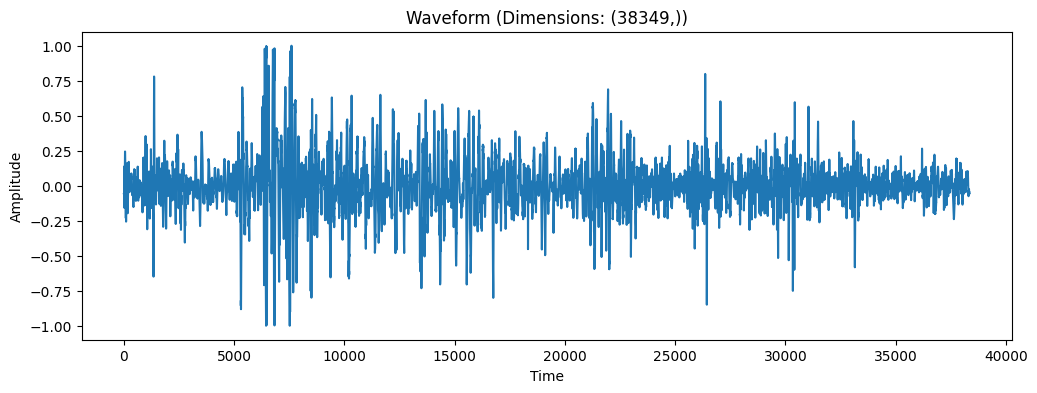

Button(description='Play Audio', style=ButtonStyle())

Output()

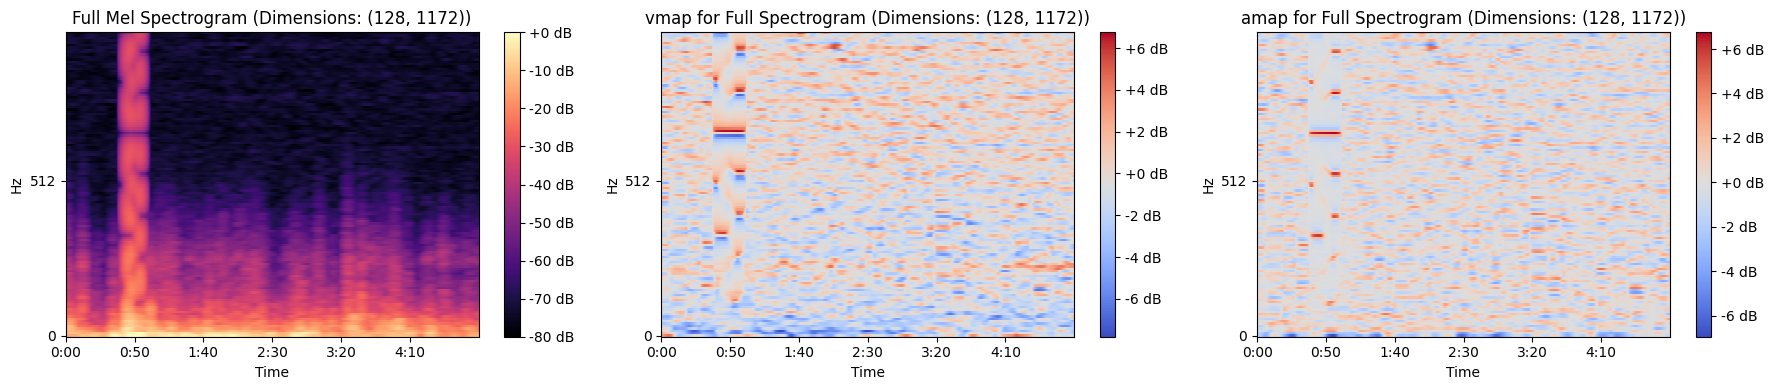

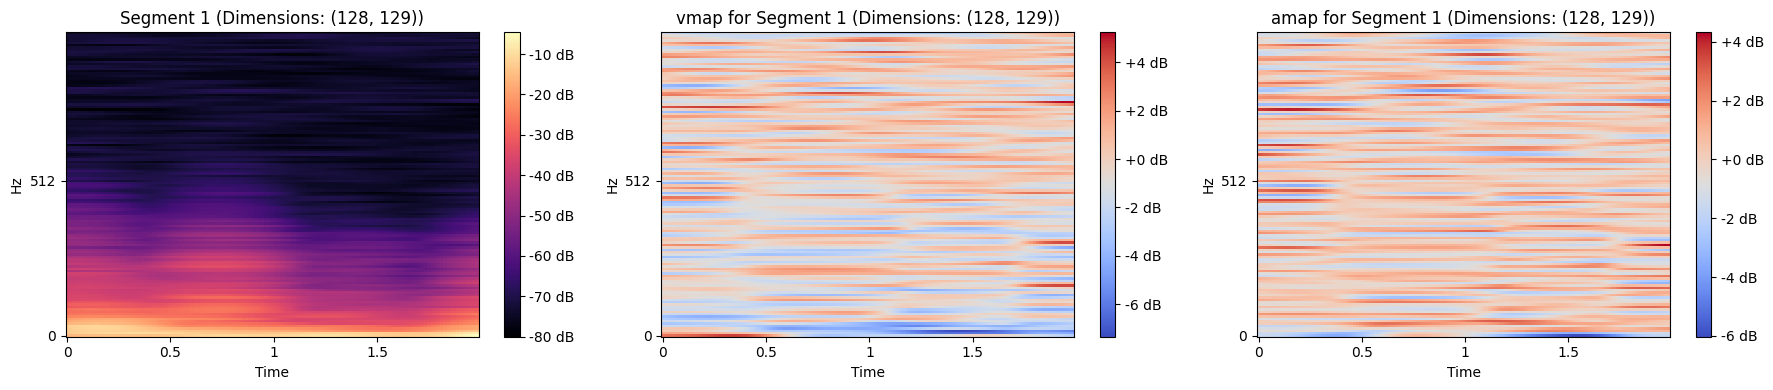

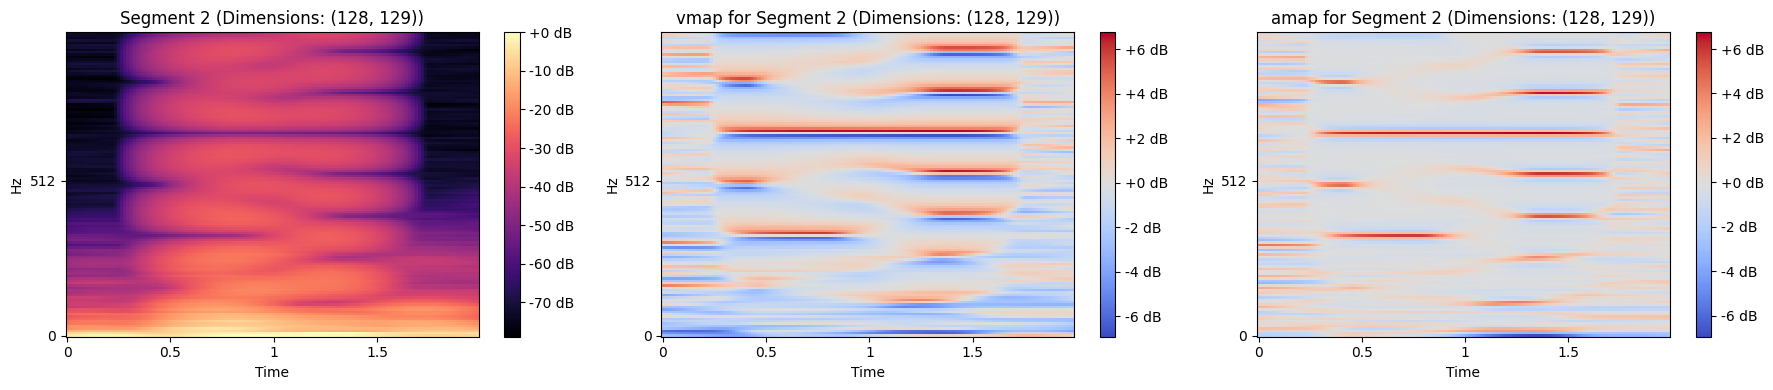

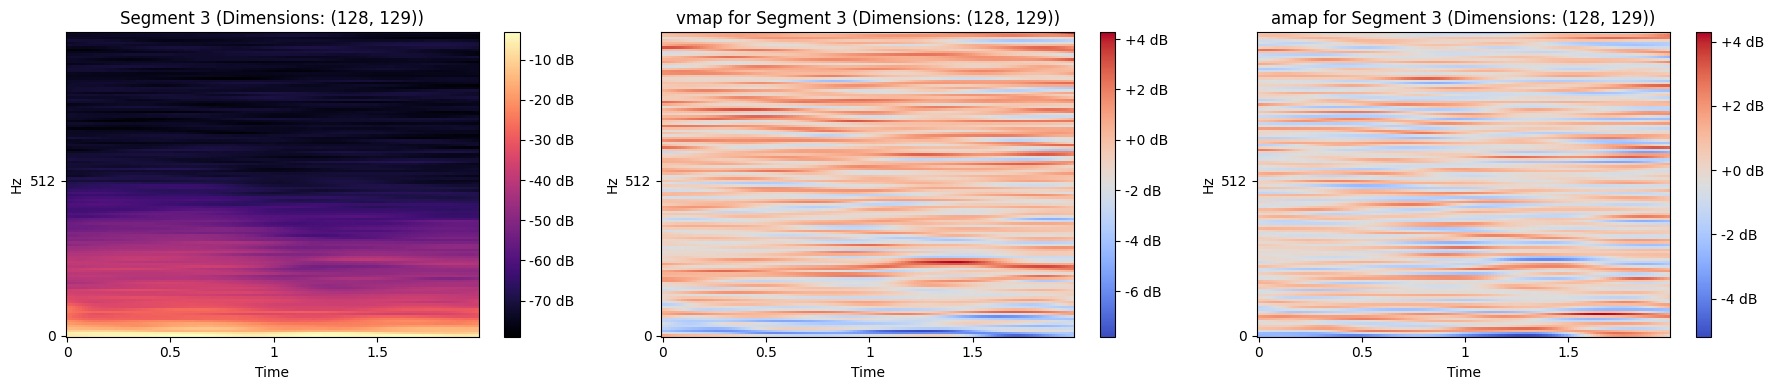

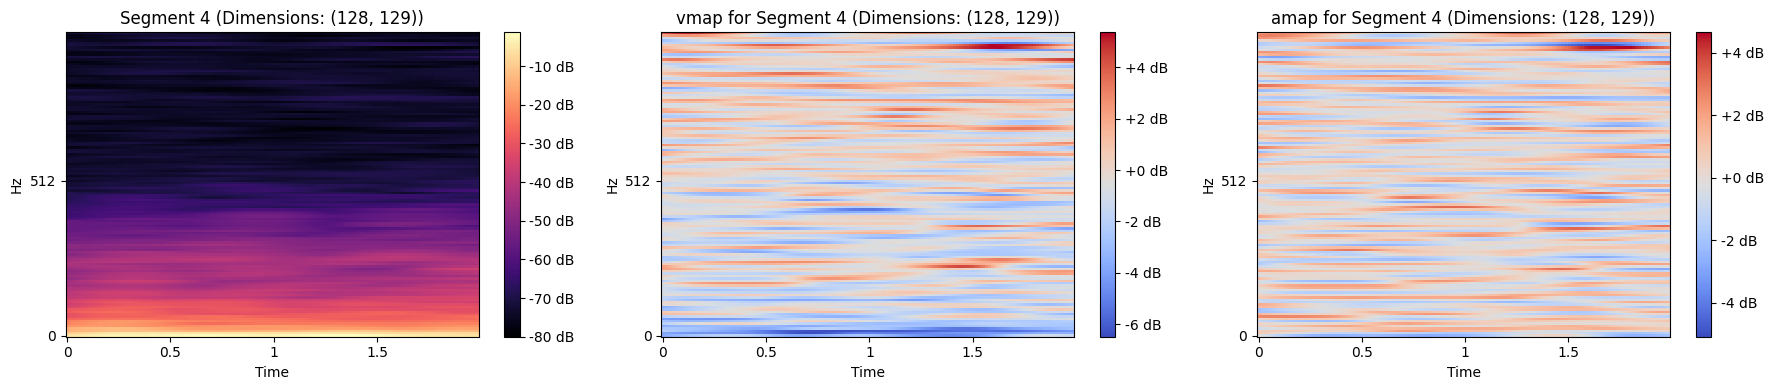

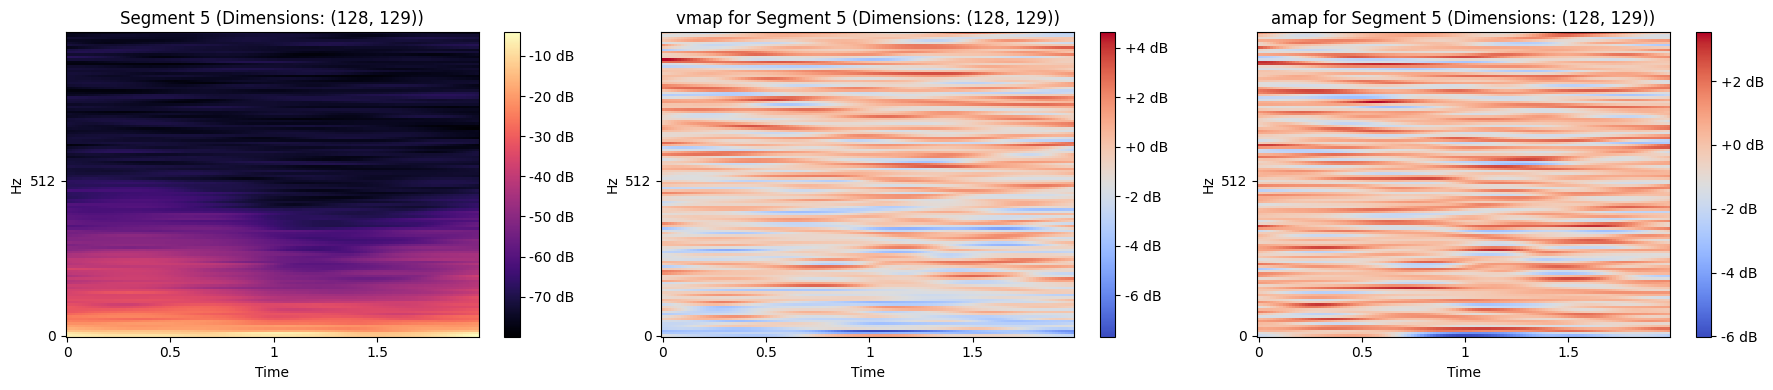

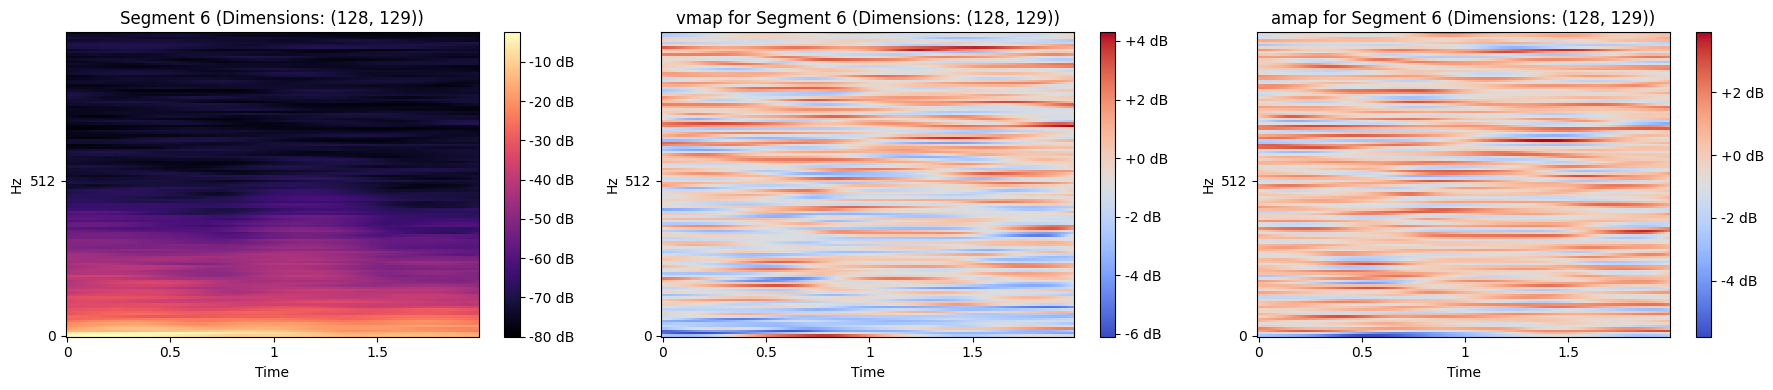

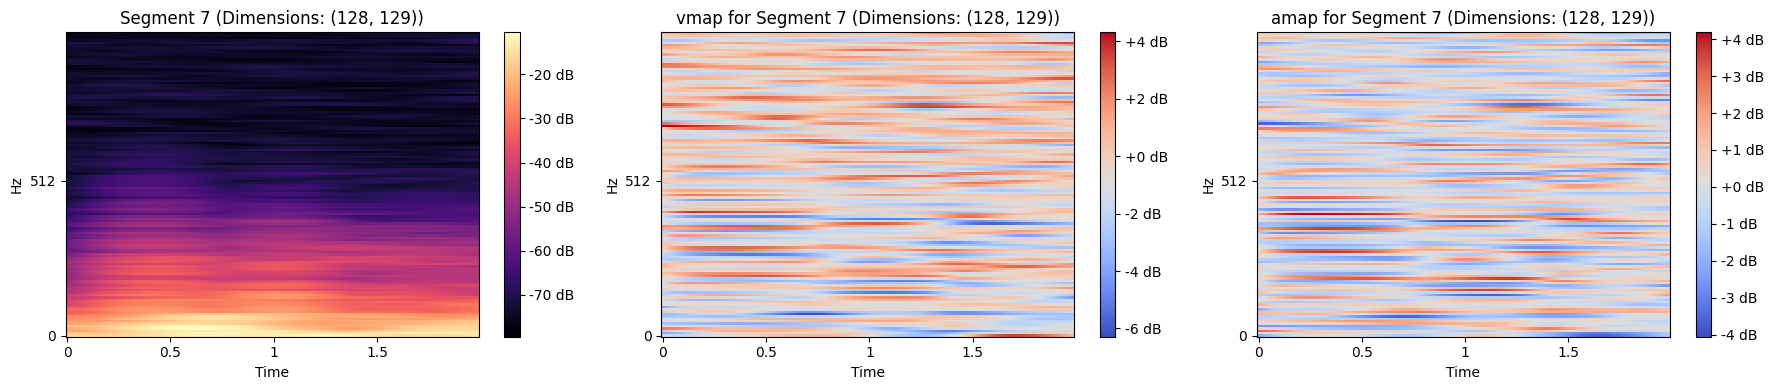

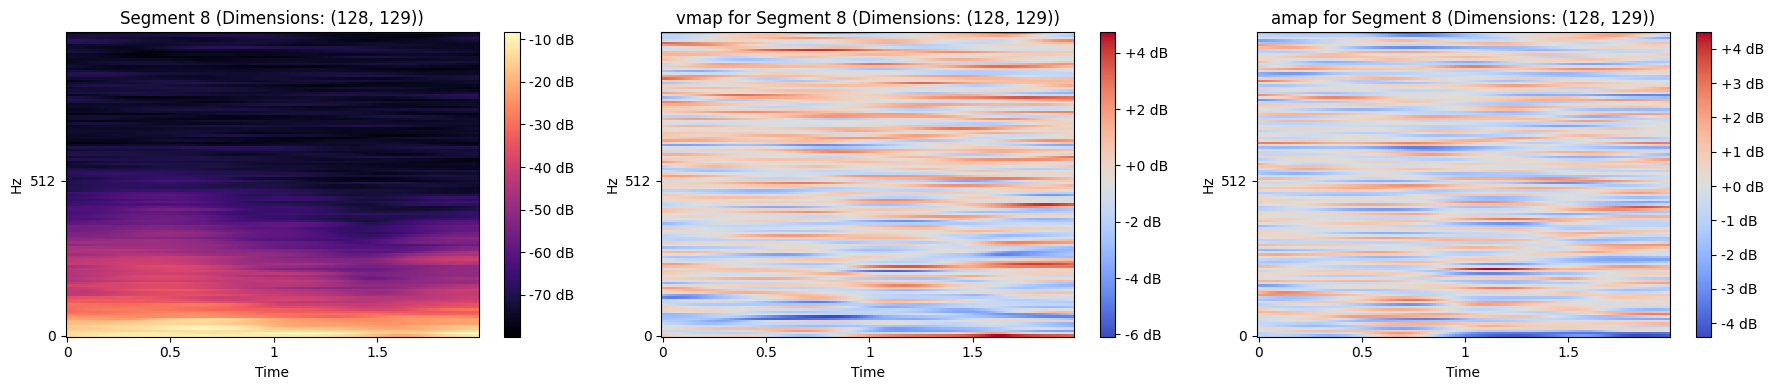

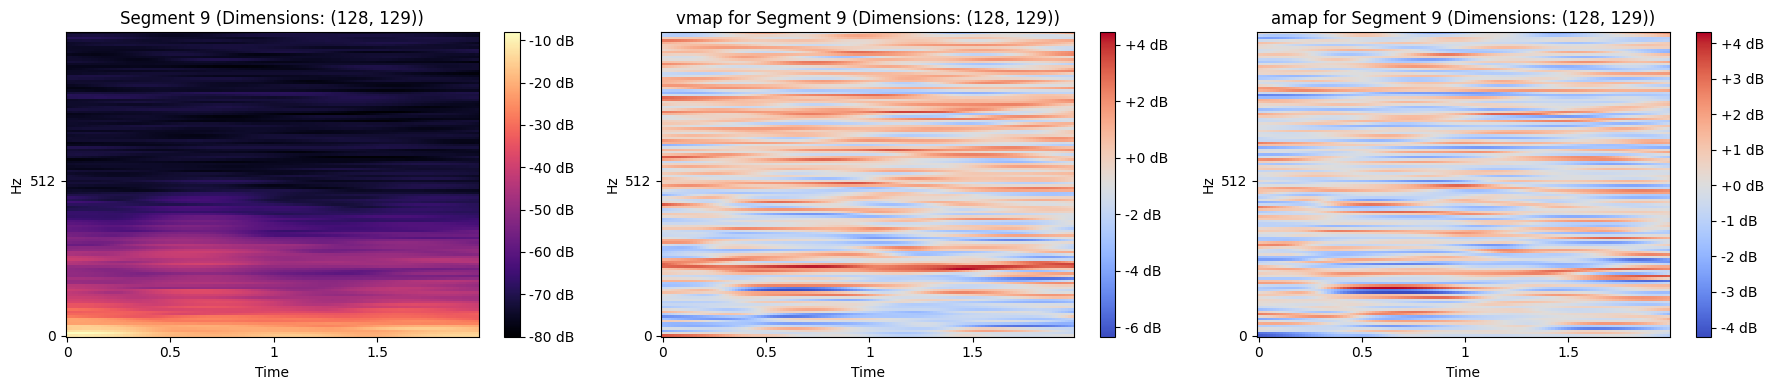

In [ ]:
wav_path = '/content/drive/My Drive/Orig_WAV_Files/27_swallow_banana_N2.wav'
plot_audio_and_segmented_spectrograms(wav_path)